In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv


In [2]:
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb

*********************  EDA
读入数据 eda参考 https://www.kaggle.com/jesucristo/fraud-complete-eda

In [3]:
%%time
train_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv', index_col='TransactionID')

train_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv', index_col='TransactionID')

sample_submission = pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv', index_col='TransactionID')

train = train_transaction.merge(train_identity, how='left', left_index=True, right_index=True)
test = test_transaction.merge(test_identity, how='left', left_index=True, right_index=True)

print(train.shape)
print(test.shape)

y_train = train['isFraud'].copy()
# del train_transaction, train_identity, test_transaction, test_identity

# Drop target, fill in NaNs
X_train = train.drop('isFraud', axis=1)
X_test = test.copy()

del train, test
# cols_v = ['V'+str(x) for x in range(1,340)]
# X_train = X_train.drop(cols_v, axis=1)
# X_test = X_test.drop(cols_v, axis=1)

(590540, 433)
(506691, 432)
CPU times: user 57.5 s, sys: 24.2 s, total: 1min 21s
Wall time: 1min 13s


查看缺失数据的情况

In [4]:
missing_values_count = X_train.isnull().sum().sort_values(ascending=False)  
print (missing_values_count[0:10])
total_cells = np.product(train_transaction.shape)
total_missing = missing_values_count.sum()
print ("% of missing data = ",(total_missing/total_cells) * 100)

id_24    585793
id_25    585408
id_07    585385
id_08    585385
id_21    585381
id_26    585377
id_22    585371
id_23    585371
id_27    585371
dist2    552913
dtype: int64
% of missing data =  49.77678729546796


时间数据的可视化，TransactionDT时间数据进行可视化

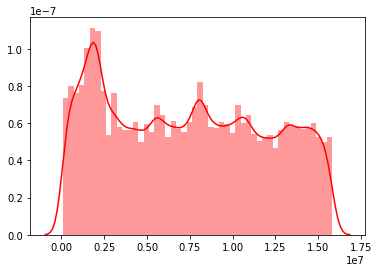

In [5]:
# fig, ax = plt.subplots(1, 2, figsize=(18,4))

# time_val = train_transaction['TransactionDT'].values

# sns.distplot(time_val, ax=ax[0], color='r')
# ax[0].set_title('Distribution of TransactionDT', fontsize=14)
# ax[1].set_xlim([min(time_val), max(time_val)])

# sns.distplot(np.log(time_val), ax=ax[1], color='b')
# ax[1].set_title('Distribution of LOG TransactionDT', fontsize=14)
# ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

# plt.show()

time_val = train_transaction['TransactionDT'].values
sns.distplot(time_val, color='r')
plt.show()

输出训练集和测试集的时间，查看是否有时间的重叠

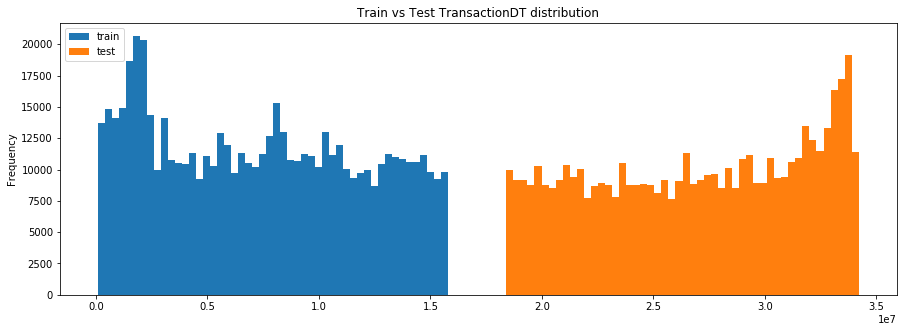

In [6]:
train_transaction['TransactionDT'].plot(kind='hist',
                                        figsize=(15, 5),
                                        label='train',
                                        bins=50,
                                        title='Train vs Test TransactionDT distribution')
test_transaction['TransactionDT'].plot(kind='hist',
                                       label='test',
                                       bins=50)
plt.legend()
plt.show()

查看基于时间的C列的特征情况

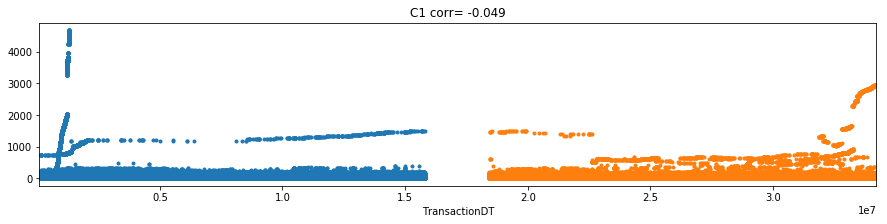

In [7]:
c_features = list(train_transaction.columns[16:17])
for i in c_features:
    cor = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i])[0,1]
    train_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    test_transaction.set_index('TransactionDT')[i].plot(style='.', title=i+" corr= "+str(round(cor,3)), figsize=(15, 3))
    plt.show()

查看V特征和时间TransactionDT的关系

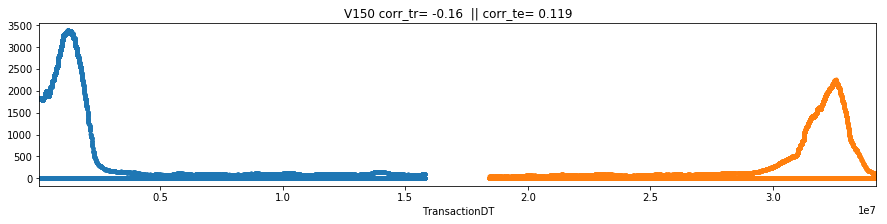

In [8]:
i = "V150"
cor_tr = np.corrcoef(train_transaction['TransactionDT'], train_transaction[i].fillna(-1))[0,1]
cor_te = np.corrcoef(test_transaction['TransactionDT'], test_transaction[i].fillna(-1))[0,1]
train_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+" || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
test_transaction.set_index('TransactionDT')[i].fillna(-1).plot(style='.', title=i+" corr_tr= "+str(round(cor_tr,3))+"  || corr_te= "+str(round(cor_te,3)), figsize=(15, 3))
plt.show()

查看TransactionAmt属性，分布

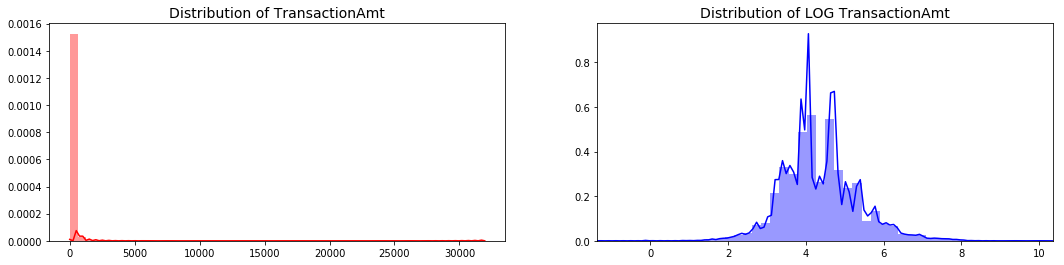

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_val = train_transaction['TransactionAmt'].values

sns.distplot(time_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of TransactionAmt', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

sns.distplot(np.log(time_val), ax=ax[1], color='b')
ax[1].set_title('Distribution of LOG TransactionAmt', fontsize=14)
ax[1].set_xlim([min(np.log(time_val)), max(np.log(time_val))])

plt.show()

查看D特征的唯一值

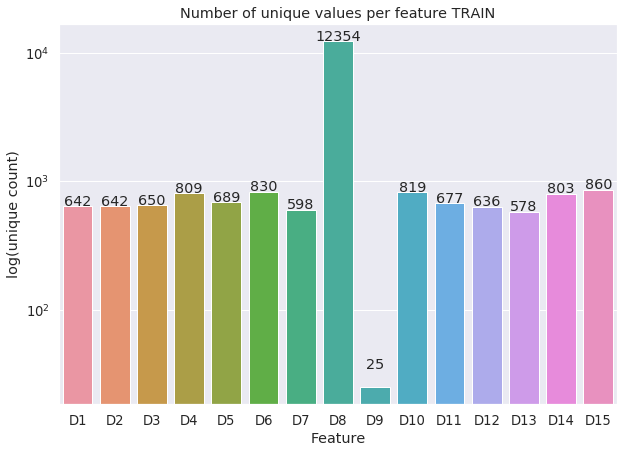

In [10]:
plt.figure(figsize=(10, 7))
d_features = list(train_transaction.columns[30:45])
uniques = [len(train_transaction[col].unique()) for col in d_features]
sns.set(font_scale=1.2)
ax = sns.barplot(d_features, uniques, log=True)
ax.set(xlabel='Feature', ylabel='log(unique count)', title='Number of unique values per feature TRAIN')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 10,
            uniq,
            ha="center") 

查看ProductCD标签的值

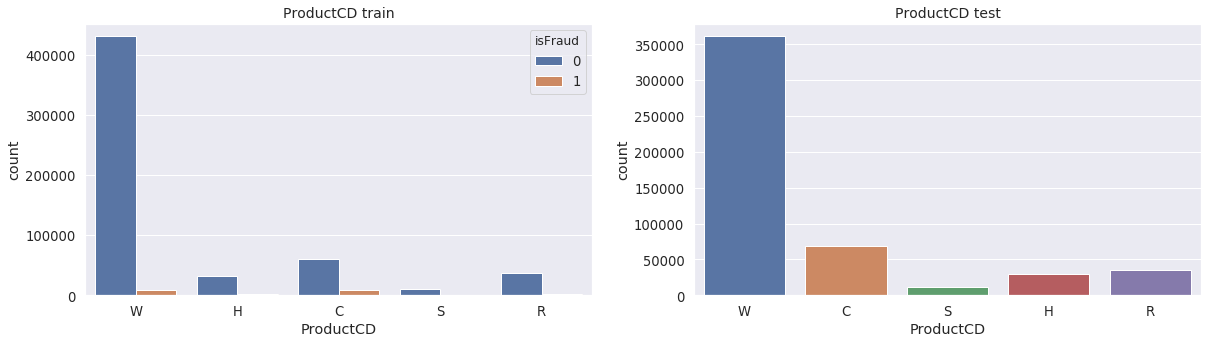

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))

sns.countplot(x="ProductCD", ax=ax[0], hue = "isFraud", data=train_transaction)
ax[0].set_title('ProductCD train', fontsize=14)
sns.countplot(x="ProductCD", ax=ax[1], data=test_transaction)
ax[1].set_title('ProductCD test', fontsize=14)
plt.show()

参考：https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
检查V特征存在，进行特征删除，根据特征之间的相关性。

1.找出相同的NAN的值
2.在相同的NAN值的情况下，画出相关性的图
3.使用reduce_group减少特征的数量，通过超过0.75的关联性进行确定。

In [12]:
import gc
nans_df = X_train.isna()
nans_groups={}
i_cols = ['V'+str(i) for i in range(1,340)]
for col in X_train.columns:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

for k,v in nans_groups.items():
    print('####### NAN count =',k)
    print(v)

####### NAN count = 0
['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']
####### NAN count = 8933
['card2']
####### NAN count = 1565
['card3']
####### NAN count = 1577
['card4']
####### NAN count = 4259
['card5']
####### NAN count = 1571
['card6']
####### NAN count = 65706
['addr1', 'addr2']
####### NAN count = 352271
['dist1']
####### NAN count = 552913
['dist2']
####### NAN count = 94456
['P_emaildomain']
####### NAN count = 453249
['R_emaildomain']
####### NAN count = 1269
['D1', 'V281', 'V282', 'V283', 'V288', 'V289', 'V296', 'V300', 'V301', 'V313', 'V314', 'V315']
####### NAN count = 280797
['D2']
####### NAN count = 262878
['D3']
####### NAN count = 168922
['D4']
####### NAN count = 309841
['D5']
####### NAN count = 517353
['D6']
####### NAN count = 551623
['D7']
####### NAN count = 515614
['D8', 'D9', 'id_09', 'id_10']
####### NAN count = 76022
['D10']
####### NAN count = 279287
['D11

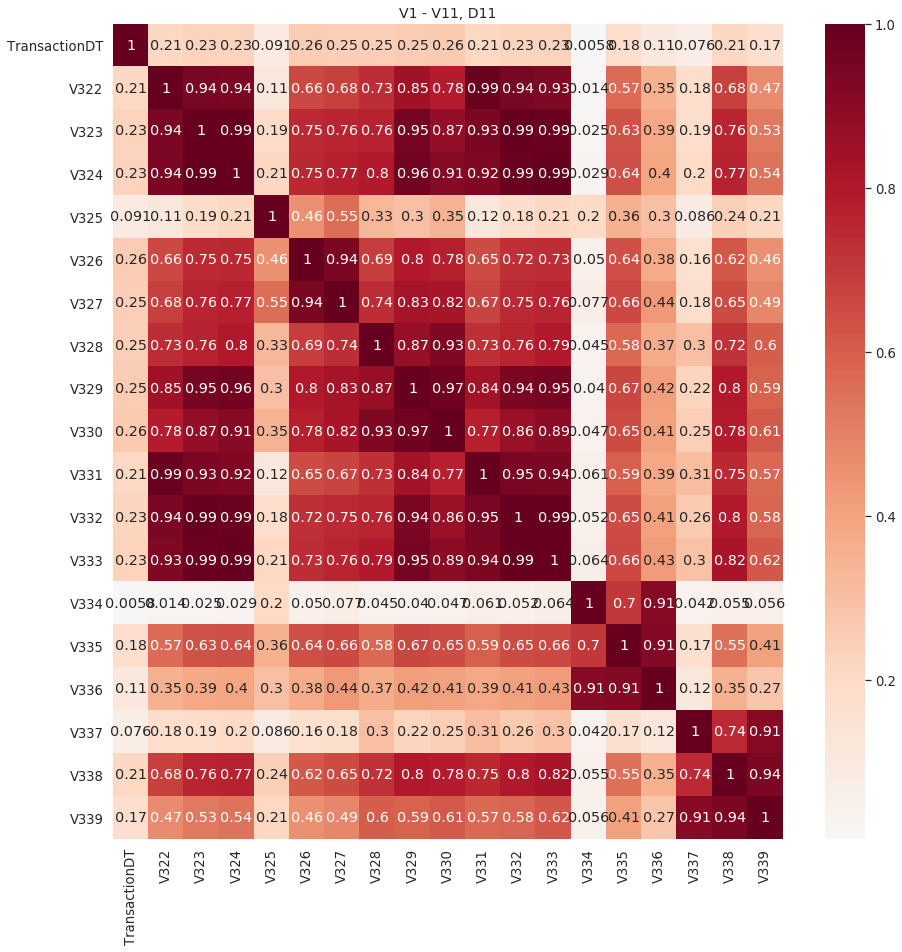

In [13]:
Vs = nans_groups[508189]
Vtitle = 'V1 - V11, D11'
def make_corr(Vs,Vtitle=''):
    cols = ['TransactionDT'] + Vs
    plt.figure(figsize=(15,15))
    sns.heatmap(X_train[cols].corr(), cmap='RdBu_r', annot=True, center=0.0)
    if Vtitle!='': plt.title(Vtitle,fontsize=14)
    else: plt.title(Vs[0]+' - '+Vs[-1],fontsize=14)
    plt.show()
make_corr(Vs,Vtitle)

In [14]:
grps = [[1],[2,3],[4,5],[6,7],[8,9],[10,11]]
def reduce_group(grps,c='V'):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = X_train[c+str(gg)].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
reduce_group(grps)

Use these [1, 3, 4, 6, 8, 11]
